In [360]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
rowCols = ['Percent Black', 'Percent White', 'Percent Asian', 'Percent Hispanic']
neededCols = [rowCols[:1][0], 'Average Score (SAT Math)']
df = pd.read_csv('scores.csv')
df.shape

(435, 22)

In [361]:
for col in neededCols:
    df = df[pd.notnull(df[col])]
df.shape

(375, 22)

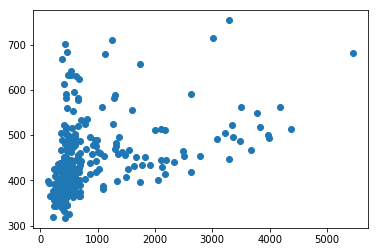

In [362]:
plt.scatter(df['Student Enrollment'], df['Average Score (SAT Math)'])

In [363]:
df['Percent Asian'] = pd.to_numeric(df['Percent Asian'].map(lambda x: x.strip('%')))
df['Percent Black'] = pd.to_numeric(df['Percent Black'].map(lambda x: x.strip('%')))

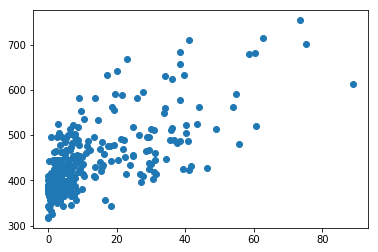

In [364]:
plt.scatter(df['Percent Asian'], df['Average Score (SAT Math)'])

In [365]:
# split the data into training / testing sets
x_train = df[['Percent Asian','Average Score (SAT Reading)']][:20]
x_test = df[['Percent Asian','Average Score (SAT Reading)']][20:40]

y_train = df['Average Score (SAT Math)'][:20].values.reshape(-1,1)
y_test = df['Average Score (SAT Math)'][20:40].values.reshape(-1,1)

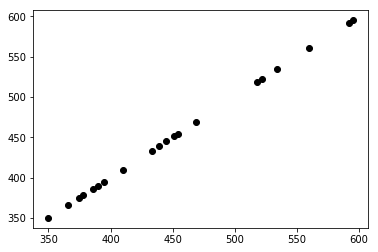

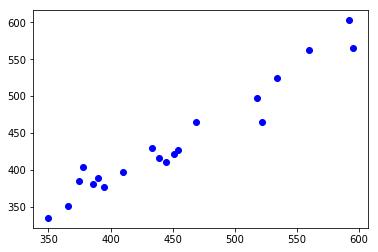

In [366]:
# create a linear regression object
regr = linear_model.LinearRegression()

# train the model using the training sets
regr.fit(x_train, y_train)

# make predicitons using the testing set
y_predictions = regr.predict(x_test)

plt.scatter(y_test, y_test, color="black")
plt.xticks()
plt.yticks()

plt.show()

plt.scatter(y_test, y_predictions, color="blue")
plt.show()

In [367]:
# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print("Mean squared error: %.2f"
     % mean_squared_error(y_test, y_predictions))

# Explained variance score: 1 is the perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_predictions))

Coefficients: 
 [[2.08970883 0.82346527]]
Mean squared error: 486.22
Variance score: 0.91
